# COVID analysis

some EDA on covid 19

In [39]:
# MAIN Libraries
import numpy as np
import pandas as pd 
pd.options.mode.chained_assignment = None  # default='warn'
import time
import datetime
from datetime import datetime, date,timedelta
from scipy import integrate, optimize
from scipy.integrate import odeint
import warnings
warnings.filterwarnings('ignore')
import os

#### PLOT
# plotly
import plotly
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
#pio.templates.default = "plotly_dark"
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.figure_factory as ff

#matplot
import matplotlib 
import matplotlib.pyplot as plt
from matplotlib import ticker
import matplotlib.dates as dates
%matplotlib inline
matplotlib.style.use('ggplot')

import seaborn as sns 

######### ML lib

#import lightgbm as lgb
#import xgboost as xgb
#from xgboost import plot_importance, plot_tree
#import sklearn 
#from sklearn.model_selection import RandomizedSearchCV, GridSearchCV,train_test_split 
#from sklearn.linear_model import LinearRegression
#from sklearn import preprocessing, svm, metrics
#from sklearn import linear_model
#from sklearn.metrics import mean_squared_error,explained_variance_score



Get data
1. Data are from https://github.com/CSSEGISandData/COVID-19 (select froom the web-data branch, rather than from master branch).This is the data repository for the 2019 Novel Coronavirus Visual Dashboard operated by the Johns Hopkins University Center for Systems Science and Engineering (JHU CSSE). Also, Supported by ESRI Living Atlas Team and the Johns Hopkins University Applied Physics Lab (JHU APL)
COVID-19 Data Repository by the Center for Systems Science and Engineering (CSSE) at Johns Hopkins University)

For field description see https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data#daily-reports-csse_covid_19_daily_reports

2. Our World in Data  website (https://covid.ourworldindata.org/data/owid-covid-data.csv )
see the description here https://github.com/owid/covid-19-data/tree/master/public/data

In [40]:
#latest data country, aggregated  
latest_country_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/web-data/data/cases_country.csv')
#latest timeseries data, country, day
cleaned_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/web-data/data/cases_time.csv')
owid_data_df = pd.read_csv('https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv')


In [41]:
latest_country_df.head()

,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Incident_Rate,People_Tested,People_Hospitalized,Mortality_Rate,UID,ISO3
0,Afghanistan,2020-11-04 01:24:57,33.93911,67.709953,41728.0,1544.0,34355.0,5829.0,107.191827,NaN,NaN,3.700153,4,AFG
1,Albania,2020-11-04 01:24:57,41.15330,20.168300,21904.0,532.0,11473.0,9899.0,761.136980,NaN,NaN,2.428780,8,ALB
2,Algeria,2020-11-04 01:24:57,28.03390,1.659600,58979.0,1980.0,40577.0,16422.0,134.498511,NaN,NaN,3.357127,12,DZA
3,Andorra,2020-11-04 01:24:57,42.50630,1.521800,4910.0,75.0,3627.0,1208.0,6354.753122,NaN,NaN,1.527495,20,AND
4,Angola,2020-11-04 01:24:57,-11.20270,17.873900,11577.0,291.0,5230.0,6056.0,35.224565,NaN,NaN,2.513605,24,AGO


In [42]:
latest_country_df.shape

(190, 14)

In [43]:
cleaned_df.head()

,Country_Region,Last_Update,Confirmed,Deaths,Recovered,Active,Delta_Confirmed,Delta_Recovered,Incident_Rate,People_Tested,People_Hospitalized,Province_State,FIPS,UID,iso3,Report_Date_String,Delta_Deaths
0,Afghanistan,1/22/20,0,0,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,4,AFG,2020/01/22,0.0
1,Afghanistan,1/23/20,0,0,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,4,AFG,2020/01/23,0.0
2,Afghanistan,1/24/20,0,0,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,4,AFG,2020/01/24,0.0
3,Afghanistan,1/25/20,0,0,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,4,AFG,2020/01/25,0.0
4,Afghanistan,1/26/20,0,0,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,4,AFG,2020/01/26,0.0


In [44]:
cleaned_df.shape

(70928, 17)

In [45]:
owid_data_df.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
0,ABW,North America,Aruba,2020-03-13,2.0,2.0,NaN,NaN,0.0,NaN,...,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29,NaN
1,ABW,North America,Aruba,2020-03-19,NaN,NaN,0.286,NaN,NaN,0.0,...,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29,NaN
2,ABW,North America,Aruba,2020-03-20,4.0,2.0,0.286,NaN,0.0,0.0,...,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29,NaN
3,ABW,North America,Aruba,2020-03-21,NaN,NaN,0.286,NaN,NaN,0.0,...,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29,NaN
4,ABW,North America,Aruba,2020-03-22,NaN,NaN,0.286,NaN,NaN,0.0,...,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29,NaN


In [46]:
owid_data_df.shape

(54390, 49)

In [47]:
#just see the data for world by selecting location == world
owid_data_df.query('location=="World"' )

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
53772,OWID_WRL,NaN,World,2019-12-31,27.0,27.0,NaN,NaN,0.0,NaN,...,15469.207,10.0,233.07,8.51,6.434,34.635,60.13,2.705,72.58,NaN
53773,OWID_WRL,NaN,World,2020-01-01,27.0,0.0,NaN,NaN,0.0,NaN,...,15469.207,10.0,233.07,8.51,6.434,34.635,60.13,2.705,72.58,NaN
53774,OWID_WRL,NaN,World,2020-01-02,27.0,0.0,NaN,NaN,0.0,NaN,...,15469.207,10.0,233.07,8.51,6.434,34.635,60.13,2.705,72.58,NaN
53775,OWID_WRL,NaN,World,2020-01-03,44.0,17.0,NaN,NaN,0.0,NaN,...,15469.207,10.0,233.07,8.51,6.434,34.635,60.13,2.705,72.58,NaN
53776,OWID_WRL,NaN,World,2020-01-04,44.0,0.0,NaN,NaN,0.0,NaN,...,15469.207,10.0,233.07,8.51,6.434,34.635,60.13,2.705,72.58,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54076,OWID_WRL,NaN,World,2020-10-30,45182859.0,547141.0,477533.286,1182743.0,7172.0,6238.286,...,15469.207,10.0,233.07,8.51,6.434,34.635,60.13,2.705,72.58,NaN
54077,OWID_WRL,NaN,World,2020-10-31,45720238.0,537379.0,484479.000,1190029.0,7286.0,6374.286,...,15469.207,10.0,233.07,8.51,6.434,34.635,60.13,2.705,72.58,NaN
54078,OWID_WRL,NaN,World,2020-11-01,46173999.0,453761.0,483646.286,1196384.0,6355.0,6455.000,...,15469.207,10.0,233.07,8.51,6.434,34.635,60.13,2.705,72.58,NaN
54079,OWID_WRL,NaN,World,2020-11-02,46658636.0,484637.0,490171.429,1201636.0,5252.0,6570.857,...,15469.207,10.0,233.07,8.51,6.434,34.635,60.13,2.705,72.58,NaN


## EDA

Fill the missing values

In [48]:
columnsToClean = ['Confirmed', 'Deaths', 'Recovered', 'Active']

In [49]:
#print(" \nCount total NaN at each column in the DataFrame : \n",latest_country_df.isnull().sum()) 

In [50]:
latest_country_df[['Country_Region']] = latest_country_df[['Country_Region']].fillna('')
latest_country_df[columnsToClean] = latest_country_df[columnsToClean].fillna(0)

In [51]:
#change united kingdom to UK, need this later
latest_country_df.loc[latest_country_df['Country_Region'] == "United Kingdom", "Country_Region"] = "UK"
latest_country_df.head()

,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Incident_Rate,People_Tested,People_Hospitalized,Mortality_Rate,UID,ISO3
0,Afghanistan,2020-11-04 01:24:57,33.93911,67.709953,41728.0,1544.0,34355.0,5829.0,107.191827,NaN,NaN,3.700153,4,AFG
1,Albania,2020-11-04 01:24:57,41.15330,20.168300,21904.0,532.0,11473.0,9899.0,761.136980,NaN,NaN,2.428780,8,ALB
2,Algeria,2020-11-04 01:24:57,28.03390,1.659600,58979.0,1980.0,40577.0,16422.0,134.498511,NaN,NaN,3.357127,12,DZA
3,Andorra,2020-11-04 01:24:57,42.50630,1.521800,4910.0,75.0,3627.0,1208.0,6354.753122,NaN,NaN,1.527495,20,AND
4,Angola,2020-11-04 01:24:57,-11.20270,17.873900,11577.0,291.0,5230.0,6056.0,35.224565,NaN,NaN,2.513605,24,AGO


In [52]:
#just check all the values for  one country
is_uk=latest_country_df['Country_Region'] == "UK"
is_uk_df=latest_country_df[is_uk]
is_uk_df

,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Incident_Rate,People_Tested,People_Hospitalized,Mortality_Rate,UID,ISO3
180,UK,2020-11-04 01:24:57,55.0,-3.0,1077099.0,47340.0,2906.0,1026853.0,1586.628961,NaN,NaN,4.395139,826,GBR


In [53]:
dataToplot_df = latest_country_df.drop(['Last_Update', 'Lat','Long_','Incident_Rate','People_Tested','People_Hospitalized','Mortality_Rate','UID','ISO3'], axis=1) 
dataToplot_df=dataToplot_df.sort_values(by = 'Confirmed', ascending = False).head(10).reset_index()
#dataToplot_df.sort_values(by = 'Confirmed', descending = True).tail(10).reset_index()
#Data_to_plot = latest_country_df['deaths', 'confirmed'].sum().reset_index().sort_values(by = 'confirmed', ascending = True).tail(20)
#Data_to_plot = pd.melt(Data_to_plot, id_vars=['countriesAndTerritories'], value_vars=['confirmed', 'deaths'])

In [54]:
# melt() function is used to unpivot a given DataFrame from wide format to long format
dataToplot_df = pd.melt(dataToplot_df, id_vars=['Country_Region'], value_vars=['Confirmed','Active' , 'Recovered','Deaths'])
#dataToplot_df.head()
#just print out variables related to US
print (dataToplot_df.loc[dataToplot_df['Country_Region'] == 'US'])

   Country_Region   variable      value
0              US  Confirmed  9377579.0
10             US     Active  5440056.0
20             US  Recovered  3705130.0
30             US     Deaths   232538.0


### Top 10 Countries with highest numbers of confirmed cases (and other corresponding values for those countries)

In [55]:
fig = px.bar(dataToplot_df,x='value', y="Country_Region", color='variable',  text='value', orientation='h',
              color_discrete_sequence = px.colors.qualitative.Dark2)
fig.update_layout(title="Top 10 Countries with highest numbers of confirmed cases (and other corresponding values)",xaxis_title="total",
                  yaxis_title="Countries")

fig.show()


In [56]:
#find the hotspots for active, death, confirmed and recovered cases
top10_df = latest_country_df.drop(['Last_Update', 'Lat','Long_','Incident_Rate','People_Tested','People_Hospitalized','Mortality_Rate','UID','ISO3'], axis=1) 
top10_death_df = top10_df.nlargest(10, 'Deaths')
top10_confirmed_df=top10_df.nlargest(10, 'Confirmed')
top10_recovered_df=top10_df.nlargest(10, 'Recovered')
top10_active_df=top10_df.nlargest(10, 'Active')

In [57]:
fig = make_subplots(
    rows=2, cols=2,
    specs=[[{"type": "bar"}, {"type": "bar"}],
           [{"type": "bar"}, {"type": "bar"}]],
    subplot_titles=("Top 10 Countries with Confirmed Cases","Top 10 Countries with Death",
                    "Top 10 Countries with Recovered Cases", "Top 10 Countries with Active Cases")
)

fig.add_trace(go.Bar(name='Confirmed',text='Confirmed', x=top10_confirmed_df['Country_Region'], 
                     y=top10_confirmed_df['Confirmed']), row=1, col=1)


fig.add_trace(go.Bar(name='Deaths',text='Deaths', x=top10_death_df['Country_Region'],
                     y=top10_death_df['Deaths']), row=1, col=2)

fig.add_trace(go.Bar(name='Recovered', text='Recovered',x=top10_active_df['Country_Region'],
                     y=top10_recovered_df['Recovered']),row=2, col=1)

fig.add_trace(go.Bar(name='Active',text='Active', x=top10_recovered_df['Country_Region'], 
                     y=top10_active_df['Active']), row=2, col=2)

fig.update_layout(height=700,title_text="World top 10 countries with Covid-19 Cases", showlegend=False)


In [58]:
owid_covid_data_Selected = owid_data_df[['date','new_cases','new_deaths']]
owid_covid_data_Selected.tail()


,date,new_cases,new_deaths
54385,2020-10-30,NaN,NaN
54386,2020-10-31,NaN,NaN
54387,2020-11-01,NaN,NaN
54388,2020-11-02,NaN,NaN
54389,2020-11-03,NaN,NaN


### Daily deaths and new cases

In [59]:
owid_covid_newcases = owid_covid_data_Selected.groupby(['date'])['new_cases'].sum()
owid_covid_newcases = owid_covid_newcases.reset_index()
owid_covid_newcases['date'] = pd.to_datetime(owid_covid_newcases['date'])
owid_covid_newcases['date'] = owid_covid_newcases['date'].dt.strftime('%m/%d/%Y')
owid_covid_newcases.head()

,date,new_cases
0,12/31/2019,54.0
1,01/01/2020,0.0
2,01/02/2020,0.0
3,01/03/2020,34.0
4,01/04/2020,0.0


In [60]:
owid_covid_newdeaths = owid_covid_data_Selected.groupby(['date'])['new_deaths'].sum()
owid_covid_newdeaths = owid_covid_newdeaths.reset_index()
owid_covid_newdeaths['date'] = pd.to_datetime(owid_covid_newdeaths['date'])
owid_covid_newdeaths['date'] = owid_covid_newdeaths['date'].dt.strftime('%m/%d/%Y')
owid_covid_newdeaths.head()

,date,new_deaths
0,12/31/2019,0.0
1,01/01/2020,0.0
2,01/02/2020,0.0
3,01/03/2020,0.0
4,01/04/2020,0.0


In [61]:
#total world wide corona related death
owid_covid_newdeaths['new_deaths'].sum()

2414456.0

In [62]:
fig = go.Figure(data=[
    go.Line(x=owid_covid_newcases['date'], y=owid_covid_newcases['new_cases'],mode='lines',name='New Case')
    #go.Line(x=owid_covid_newdeaths['date'], y=owid_covid_newdeaths['new_deaths'],mode='lines',name='Death'),
])

fig.update_layout(
    title="World data: Daily number of new cases",
    yaxis_title="New Cases",
    xaxis_title="Date",
    showlegend=True
)


In [63]:
fig = go.Figure(data=[
    #go.Line(x=owid_covid_newcases['date'], y=owid_covid_newcases['new_cases'],mode='lines',name='New Case'),
     go.Line(x=owid_covid_newdeaths['date'], y=owid_covid_newdeaths['new_deaths'],mode='lines',name='Death'),
])

fig.update_layout(
    title="World data: daily number of deaths reported",
    yaxis_title="daily dead Cases",
    xaxis_title="Date",
    showlegend=True
)


## Forecast

###  Predictions for US with prophet

In [64]:
#owid_covid_data = pd.read_csv('https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv')
owid_data_df.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
0,ABW,North America,Aruba,2020-03-13,2.0,2.0,NaN,NaN,0.0,NaN,...,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29,NaN
1,ABW,North America,Aruba,2020-03-19,NaN,NaN,0.286,NaN,NaN,0.0,...,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29,NaN
2,ABW,North America,Aruba,2020-03-20,4.0,2.0,0.286,NaN,0.0,0.0,...,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29,NaN
3,ABW,North America,Aruba,2020-03-21,NaN,NaN,0.286,NaN,NaN,0.0,...,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29,NaN
4,ABW,North America,Aruba,2020-03-22,NaN,NaN,0.286,NaN,NaN,0.0,...,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29,NaN


In [65]:
Data_To_Process =pd.DataFrame(columns=['date','location', 'total_deaths','total_cases'], data=owid_data_df[['date','location', 'total_deaths','total_cases']].values)
Data_To_Process.head()

,date,location,total_deaths,total_cases
0,2020-03-13,Aruba,NaN,2
1,2020-03-19,Aruba,NaN,NaN
2,2020-03-20,Aruba,NaN,4
3,2020-03-21,Aruba,NaN,NaN
4,2020-03-22,Aruba,NaN,NaN


In [66]:
Data_To_Process = Data_To_Process.query('location=="United States"' )
Data_To_Process.tail(10)

,date,location,total_deaths,total_cases
50881,2020-10-25,United States,224899,8.57672e+06
50882,2020-10-26,United States,225230,8.63616e+06
50883,2020-10-27,United States,225735,8.70452e+06
50884,2020-10-28,United States,226723,8.77965e+06
50885,2020-10-29,United States,227700,8.85802e+06
50886,2020-10-30,United States,228668,8.94615e+06
50887,2020-10-31,United States,229708,9.04743e+06
50888,2020-11-01,United States,230556,9.12636e+06
50889,2020-11-02,United States,230996,9.20736e+06
50890,2020-11-03,United States,231551,9.29124e+06


In [67]:
usa_df=Data_To_Process
#set the index as date
usa_df['date'] = pd.to_datetime(usa_df['date'])
usa_df = usa_df.set_index('date')
usa_df.tail()

,location,total_deaths,total_cases
date,,,
2020-10-30,United States,228668,8.94615e+06
2020-10-31,United States,229708,9.04743e+06
2020-11-01,United States,230556,9.12636e+06
2020-11-02,United States,230996,9.20736e+06
2020-11-03,United States,231551,9.29124e+06


In [68]:
fig = go.Figure(data=[
    go.Line(x=usa_df.index, y=usa_df['total_cases'],mode='lines',name='Total cases', line_color='#ff0000'),
    #go.Line(x=regression_df.index, y=regression_df['total_deaths'],mode='lines',name='Total deaths'),
    
])

fig.update_layout(
    title="USA: cumulative data",
    yaxis_title="Counts (cumulative)",
    xaxis_title="Date",
    showlegend=True
)


In [69]:
fig = go.Figure(data=[
    
    #go.Line(x=regression_df.index, y=regression_df['total_cases'],mode='lines',name='Total cases'),
    go.Line(x=usa_df.index, y=usa_df['total_deaths'],mode='lines',name='Total deaths'),
    
])

fig.update_layout(
    title="USA: cumulative data",
    yaxis_title="Counts",
    xaxis_title="Date",
    showlegend=True
)


In [70]:
from fbprophet import Prophet
cases = Data_To_Process.groupby('date').sum()['total_cases'].reset_index()
deaths = Data_To_Process.groupby('date').sum()['total_deaths'].reset_index()

In [71]:
#Clean the Data
#follow prophet convention for naming,Prophet expect Dataframe with columns "ds" and "y" with the dates and values respectively
deaths.rename(columns={'Last_Update': 'date','total_deaths':'y'}, inplace=True)
deaths.columns = ['ds', 'y']
deaths.tail()

,ds,y
304,2020-10-30,228668.0
305,2020-10-31,229708.0
306,2020-11-01,230556.0
307,2020-11-02,230996.0
308,2020-11-03,231551.0


In [72]:
#Create the model using Prophet 0.95 confidence ( Prophet default is 80%)
ML_Model = Prophet(interval_width=0.95)
#ML_Model = Prophet(interval_width=0.95,weekly_seasonality=True)
#Fit the Model
ML_Model.fit(deaths)
#Create prediction Data for 30 days
future_df = ML_Model.make_future_dataframe(periods=30)
future_df.head()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds
0,2019-12-31
1,2020-01-01
2,2020-01-02
3,2020-01-03
4,2020-01-04


In [73]:
#predicting the future with date, and upper and lower limit of y value
Death_Forecast = ML_Model.predict(future_df)
Death_Forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
334,2020-11-29,250924.271312,236512.835047,264332.239597
335,2020-11-30,251347.199455,236556.696430,265563.145027
336,2020-12-01,251839.590568,236115.856781,266449.243564
337,2020-12-02,252697.014222,236064.429947,267959.117740
338,2020-12-03,253657.353285,236656.599676,269961.884066


In [74]:
#predicting the future with date, and upper and lower limit of y value
Death_Forecast = ML_Model.predict(future_df)
Death_Forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
334,2020-11-29,250924.271312,238459.900753,263722.261384
335,2020-11-30,251347.199455,238402.498477,264490.515104
336,2020-12-01,251839.590568,238179.597928,266026.041358
337,2020-12-02,252697.014222,238098.496661,267459.853819
338,2020-12-03,253657.353285,238708.408703,269348.655568


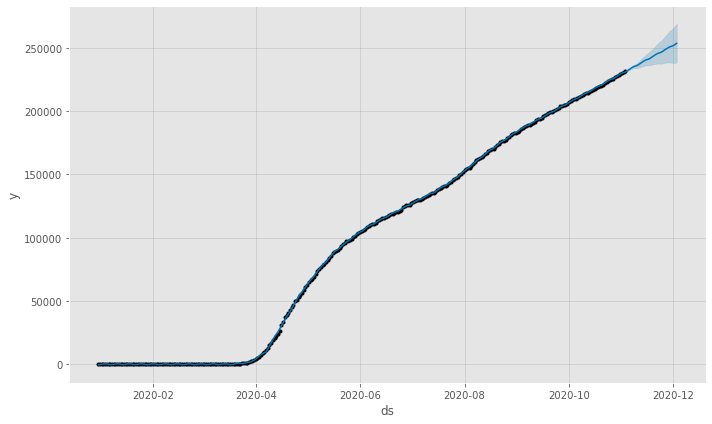

In [75]:
#Death forecasting using prophet 
#It also shows a upper and lower limit of y value, 
#blue line shows the prediction along with its lower and upper bound of the uncertainty interval.
Death_forecasting = ML_Model.plot(Death_Forecast)


In [76]:
#Death_Forecast 